In [1]:
import keras.backend as K

Using TensorFlow backend.


In [63]:
from keras.layers import Input, Add, Dense, Activation, Flatten, Dropout, Conv3D, MaxPooling3D, ZeroPadding3D, AveragePooling3D, TimeDistributed
from keras.models import Model
import config
import importlib
import os
import numpy as np

In [3]:
import tensorflow as tf

In [75]:
importlib.reload(config)

<module 'config' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\config.py'>

In [4]:
C = config.Config()

In [126]:
dims=[32,49,10]
voi_img = Input(shape=(dims[0], dims[1], dims[2], C.nb_channels))
x = Conv3D(filters=64, kernel_size=(3,3,2), activation='relu')(voi_img)
x = Conv3D(filters=64, kernel_size=(3,3,2), activation='relu')(voi_img)
x = MaxPooling3D((2, 2, 1))(x)
#x = Conv3D(filters=48, kernel_size=(1,1,1), activation='relu')(x)
x = Conv3D(filters=128, kernel_size=(3,3,2), activation='relu')(x)
x = Conv3D(filters=128, kernel_size=(3,3,2), activation='relu')(x)
x = MaxPooling3D((2, 2, 1))(x)
#x = Conv3D(filters=32, kernel_size=(1,1,1), activation='relu')(x)
#x = Conv3D(filters=32, kernel_size=(2,2,2), activation='relu')(x)
#x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
pred_class = Dense(1, activation='sigmoid')(x)#Dense(C.nb_classes, activation='softmax')(x)

In [130]:
model = Model(voi_img, pred_class)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 32, 49, 10, 2)     0         
_________________________________________________________________
conv3d_64 (Conv3D)           (None, 30, 47, 9, 64)     2368      
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 15, 23, 9, 64)     0         
_________________________________________________________________
conv3d_65 (Conv3D)           (None, 13, 21, 8, 128)    147584    
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 11, 19, 7, 128)    295040    
_________________________________________________________________
max_pooling3d_23 (MaxPooling (None, 5, 9, 7, 128)      0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 40320)             0         
__________

In [48]:
z = np.load(base_dir+"cyst\\12042703_0.npy")

In [49]:
z.shape

(32, 49, 10, 38)

In [103]:
max_samples = 5000
x = np.empty((max_samples, dims[0], dims[1], dims[2], C.nb_channels))
y = []

base_dir = "..\\liver-mr-processor\\train_imgs\\"
index = 0
for cl_num, class_name in enumerate(os.listdir(base_dir)):
    for img_fn in os.listdir(base_dir+class_name):
        #try:
        x[index] = np.load(base_dir+class_name+"\\"+img_fn)
        #except:
        #    print(class_name+"\\"+img_fn)
        index += 1
        y.append(cl_num)

x.resize((index, dims[0], dims[1], dims[2], C.nb_channels))

In [128]:
Y=y
#Y = np.array([[0,1] if y[x] == 1 else [1,0] for x in range(len(y))])
#Y = K.constant(y, dtype=tf.int32)
#Y = K.one_hot(Y, C.nb_classes)

In [106]:
X = np.array([z for z in x])

In [107]:
X.shape

(1650, 32, 49, 10, 2)

In [136]:
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
np.amax(X[650,:,:,:,0])

0.0

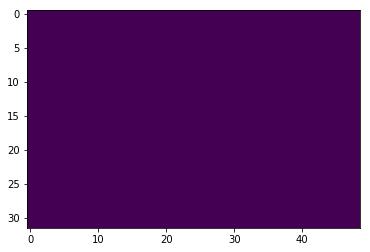

In [140]:
plt.imshow(X[0,:,:,5,0])

In [132]:
Y_ = model.predict(X)

In [131]:
hist = model.fit(X, Y, batch_size=32, epochs=8, validation_split=0.2)

Train on 1320 samples, validate on 330 samples
Epoch 1/8
1320/1320 [==============================] - 5s - loss: 2.6271 - acc: 0.8311 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/8
1320/1320 [==============================] - 4s - loss: 2.6863 - acc: 0.8333 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 3/8
1320/1320 [==============================] - 4s - loss: 2.6863 - acc: 0.8333 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 4/8
1320/1320 [==============================] - 4s - loss: 2.6863 - acc: 0.8333 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 5/8
1320/1320 [==============================] - 4s - loss: 2.6863 - acc: 0.8333 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 6/8
1320/1320 [==============================] - 4s - loss: 2.6863 - acc: 0.8333 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 7/8
1320/1320 [==============================] - 4s - loss: 2.6863 - acc: 0.8333 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 8/8
1320/1320 [=============================

In [94]:
max(sum(y)/len(y), 1-sum(y)/len(y))

0.6666666666666667

In [108]:
Y.shape

(1650, 2)

In [73]:
hist.history

{'acc': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'loss': [1.1920930376163597e-07,
  1.1920930376163597e-07,
  1.1920930376163597e-07,
  1.1920930376163597e-07,
  1.1920930376163597e-07,
  1.1920930376163597e-07,
  1.1920930376163597e-07,
  1.1920930376163597e-07],
 'val_acc': [0.33734939759036142,
  0.33734939759036142,
  0.33734939759036142,
  0.33734939759036142,
  0.33734939759036142,
  0.33734939759036142,
  0.33734939759036142,
  0.33734939759036142],
 'val_loss': [10.682890466896884,
  10.682890466896884,
  10.682890283056052,
  10.682890283056052,
  10.682890283056052,
  10.682890283056052,
  10.682890283056052,
  10.682890283056052]}